# Imaging notebook

This notebook works through the high level functions interface to crocodile, making a fake data set and then
deconvolving it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import sys, os 
sys.path.append('../..') 
print(os.getcwd())

import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

from astropy import constants as const
import scipy.special

from matplotlib import pylab
from matplotlib import pyplot as plt

from functions.clean import clean

from functions.imaging import *
from functions.image import image_show

/Users/timcornwell/Code/crocodile/examples/notebooks


We construct a VLA configuration and then shrink it to match our test image.

In [2]:
kwargs = {}

vlaa = configuration_filter(named_configuration('VLAA'), **kwargs)
vlaa.data['xyz']=vlaa.data['xyz']/30.0

Configuration: No filter implemented yet


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.arange(-numpy.pi/2.0, +numpy.pi/2.0,0.05)
frequency = numpy.arange(1.0e8, 1.50e8, 1e6)
frequency = 1.0e8*numpy.ones([1])
reffrequency = numpy.average(frequency)
direction = SkyCoord(0.0*u.rad, u.rad*numpy.pi/4, frame='icrs')
vt = simulate(vlaa, times, frequency, weight=1.0, direction=direction)

Visibility.simulate: Created 22113 rows


Plot the synthesized uv coverage, including for MFS

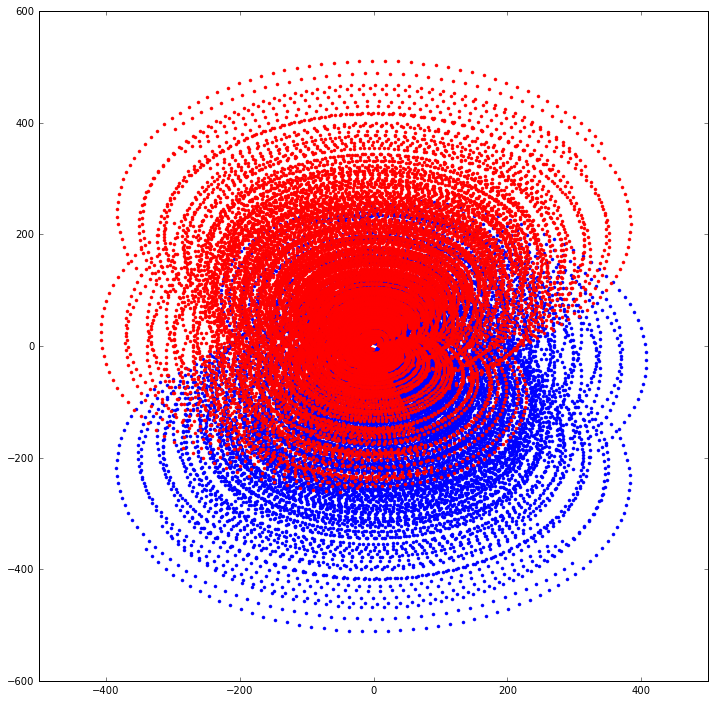

In [4]:
plt.clf()
for f in frequency:
    x=f/const.c
    plt.plot(x*vt.data['uvw'][:,0], x*vt.data['uvw'][:,1], '.', color='b')
    plt.plot(-x*vt.data['uvw'][:,0], -x*vt.data['uvw'][:,1], '.', color='r')

Read the venerable test image, constructing an image

image_from_fits: Max, min in /Users/timcornwell/Code/crocodile//./data/models/m31.MOD = 1.006458, -0.000000


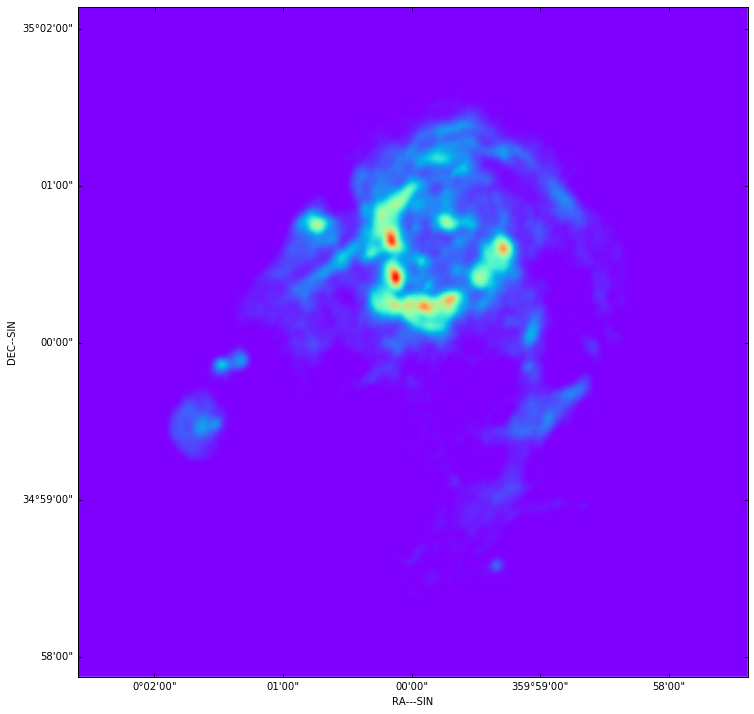

In [5]:
m31image = image_from_fits("./data/models/m31.MOD")
fig = plt.figure()
fig.add_subplot(111, projection=m31image.wcs)
plt.imshow(m31image.data, origin='lower', cmap='rainbow')
plt.xlabel('RA---SIN')
plt.ylabel('DEC--SIN')
plt.show()

This image is only 2 dimensional. We need extra axes frequency and stokes. 

In [6]:
m31image4D=image_replicate(m31image, shape=[1, 1, 1, len(frequency)])
m31sm = skymodel_from_image(m31image4D)

image_replicate: replicating shape (256, 256) to (1, 1, 256, 256)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 0.0  35.0  
CRPIX : 128.0  128.0  
NAXIS    : 256 256


Now we can predict the visibility from this model

In [7]:
kwargs={'wstep':30.0}
vt = predict(vt, m31sm, **kwargs)

imaging.predict: Predicting Visibility from sky model
imaging.wcs_from_visibility: Parsing kwargs to get definition of WCS
imaging.wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz Hz, and bandwidth 100000000.0 Hz Hz
imaging.predict: Image npixel=256, Image cellsize = 0.000278, Image FOV = 0.071111
imaging.predict: Critical cellsize = 0.000489
imaging.predict: Making w-kernel cache of 38 kernels
imaging.invert: Predicting channel 0, polarisation 0
imaging.predict: Finished predicting Visibility from sky model


To check that we got it right, plot the amplitude of the visibility.

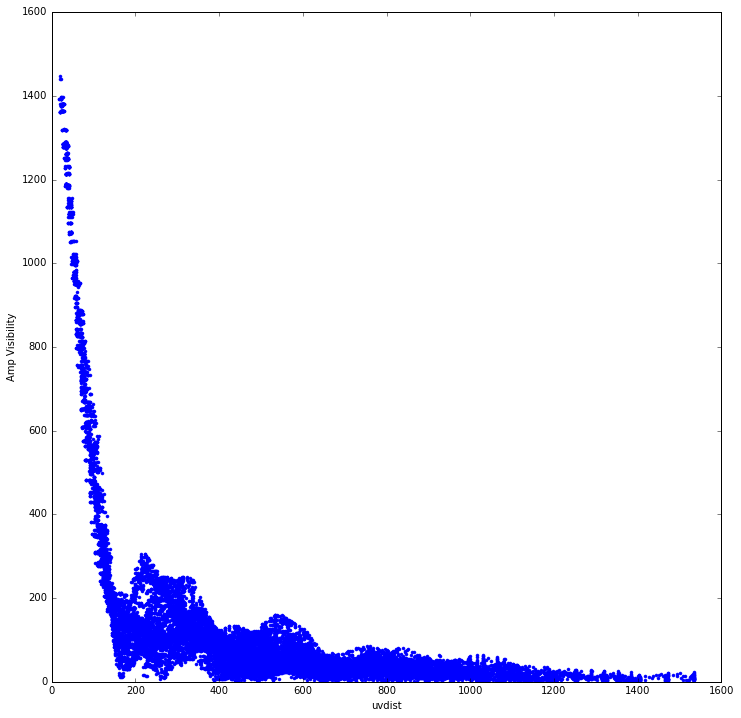

In [9]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

imaging.invert: Inverting Visibility to make dirty and psf
imaging.wcs_from_visibility: Parsing kwargs to get definition of WCS
imaging.wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz Hz, and bandwidth 100000000.0 Hz Hz
imaging.invert: Specified npixel=512, specified cellsize = 0.000400, FOV = 0.204800
imaging.invert: Critical cellsize = 0.000978
imaging.invert: Making w-kernel cache of 38 kernels
imaging.invert: Inverting channel 0, polarisation 0
imaging.invert: Finished making dirty and psf


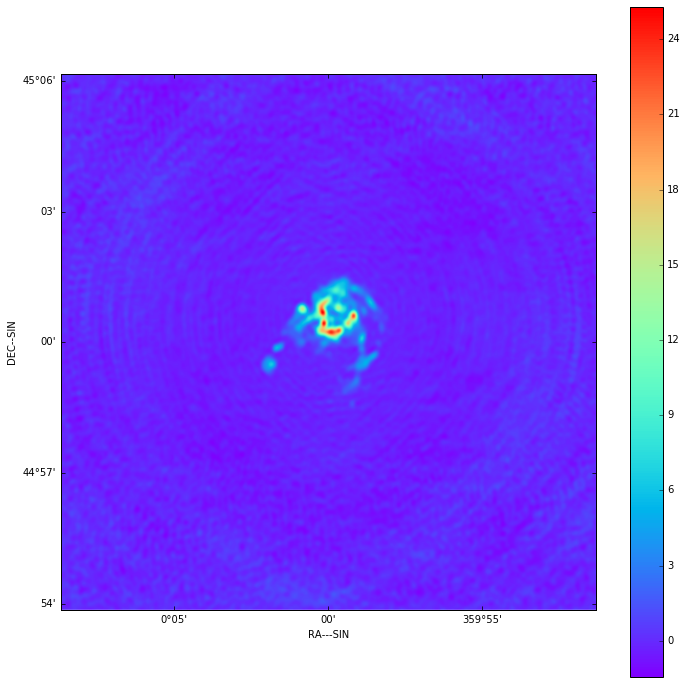

Max, min in dirty image = 25.270570, -1.429690, sum of weights = 0.054963
imaging.fitcomponent: Stubbed: Finding components in Image, adding to SkyModel


In [10]:
kwargs={}
kwargs['npixel']=512
kwargs['cellsize']=0.0004
kwargs['wstep']=30.0
dirty, psf, sumwt = invert(vt, **kwargs)
image_show(dirty)
print("Max, min in dirty image = %.6f, %.6f, sum of weights = %f" % (dirty.data.max(), dirty.data.min(), sumwt))
image_to_fits(dirty, 'dirty.fits')
image_to_fits(psf, 'psf.fits')
m31smnew, res = fitcomponent(dirty, m31sm, **kwargs)

In [11]:
kwargs={'niter':1000}
comp, residual = clean(dirty, psf, **kwargs)

clean.clean: Processing pol 0, channel 0
Peak of PSF = 1.0 at (256, 256)
Peak of Dirty = 25.2705700322 at (284, 249)
Coupling matrix =
 [[ 1.          0.97330394  0.66518085  0.13808787]
 [ 0.97330394  0.94772063  0.65149374  0.13735369]
 [ 0.66518085  0.65149374  0.48514501  0.12691051]
 [ 0.13808787  0.13735369  0.12691051  0.0739995 ]]
Max abs in dirty Image = 25.270570
Start of minor cycle
This minor cycle will stop at 1000 iterations or peak < 0.0
Minor cycle 0, peak [ 20.99469112  20.89128917  19.54047006  14.95569685] at [266, 256, 3]
Minor cycle 10, peak [ 6.35893122  6.32152949  5.81061446  3.5634394 ] at [270, 272, 3]
Minor cycle 20, peak [ 3.85016404  3.86761654  3.95560334  2.2439515 ] at [278, 251, 3]
Minor cycle 30, peak [ 2.39749372  2.39045725  2.27078158  1.36707143] at [296, 273, 3]
Minor cycle 40, peak [ 1.51756001  1.51355245  1.45396164  1.0312014 ] at [284, 300, 3]
Minor cycle 50, peak [-3.78872238 -3.74269435 -3.10448127 -0.93062417] at [282, 274, 3]
Minor cycle 

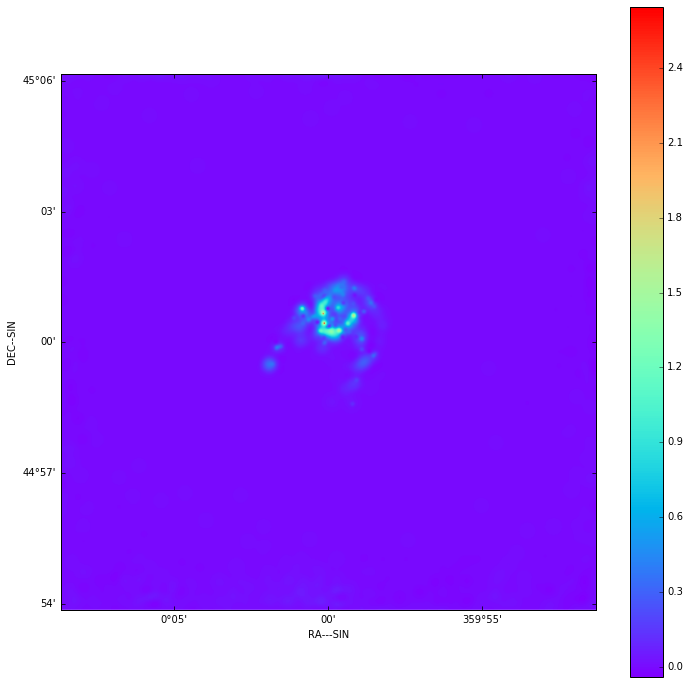

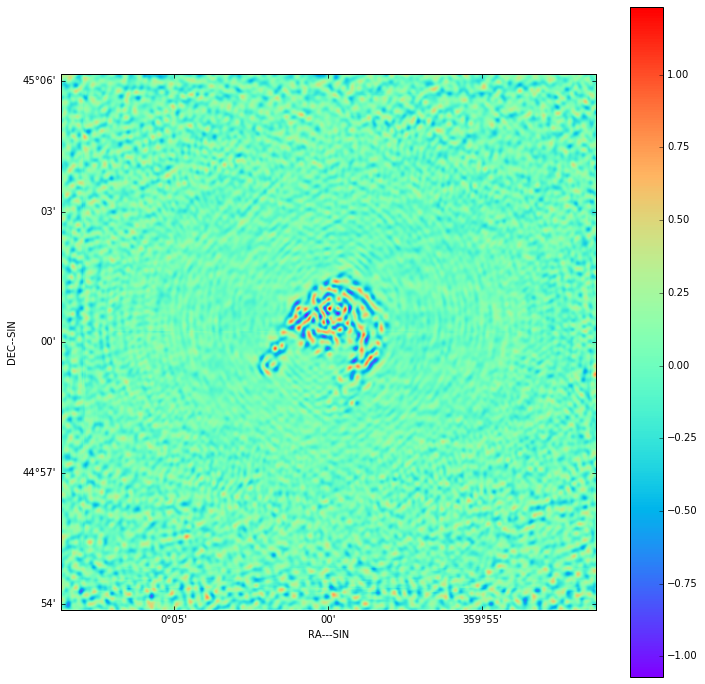

In [18]:
fig=image_show(comp)
fig=image_show(residual)

In [15]:
kwargs={'wstep':30.0}
vt = predict(vt, m31sm, **kwargs)
modelsm=skymodel_from_image(comp)
vtmodel = simulate(vlaa, times, frequency, weight=1.0, direction=direction)
vtmodel.data = vt.data.copy()
vtmodel=predict(vtmodel, modelsm,**kwargs)

imaging.predict: Predicting Visibility from sky model
imaging.wcs_from_visibility: Parsing kwargs to get definition of WCS
imaging.wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz Hz, and bandwidth 100000000.0 Hz Hz
imaging.predict: Image npixel=256, Image cellsize = 0.000278, Image FOV = 0.071111
imaging.predict: Critical cellsize = 0.000489
imaging.predict: Making w-kernel cache of 38 kernels
imaging.invert: Predicting channel 0, polarisation 0
imaging.predict: Finished predicting Visibility from sky model
Visibility.simulate: Created 22113 rows
imaging.predict: Predicting Visibility from sky model
imaging.wcs_from_visibility: Parsing kwargs to get definition of WCS
imaging.wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz Hz, and bandwidth 100000000.0 Hz Hz
imaging.predict: Image npixel=512, Image cellsize = 0.000400, Image FOV = 0.204800
imaging.pre

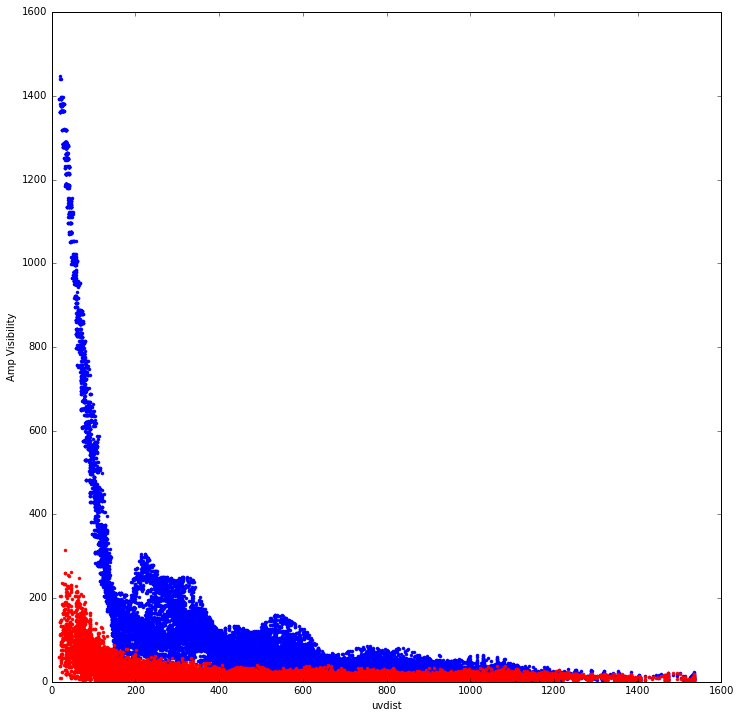

In [17]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.', color='b')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]-vtmodel.data['vis'][:,0,0]), '.', color='r')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()